In [9]:
import torch
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma, FAISS
from pdf2image import convert_from_path
from transformers import AutoTokenizer, TextStreamer, pipeline

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

## Çalışmada 3 adet doküman kullanılmıştır. Bu dokümanların içeriği futbol, Hopsworks feature store ve enflasyon ile ilgilidir.

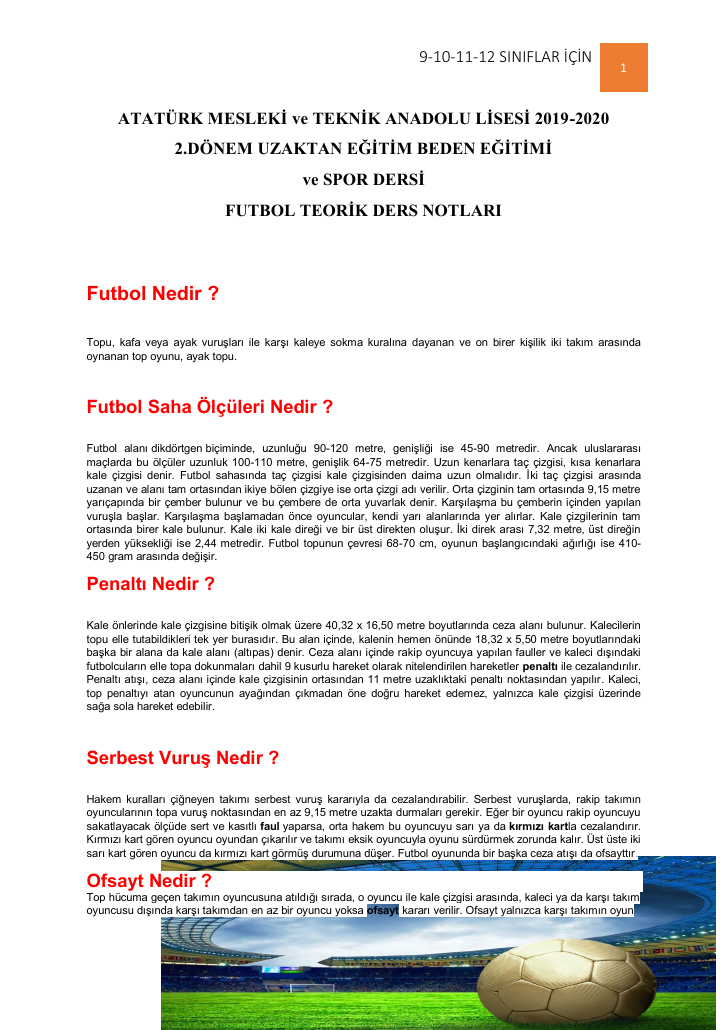

In [2]:
futbol = convert_from_path("pdfs/futbol.pdf", dpi=88)
futbol[0]

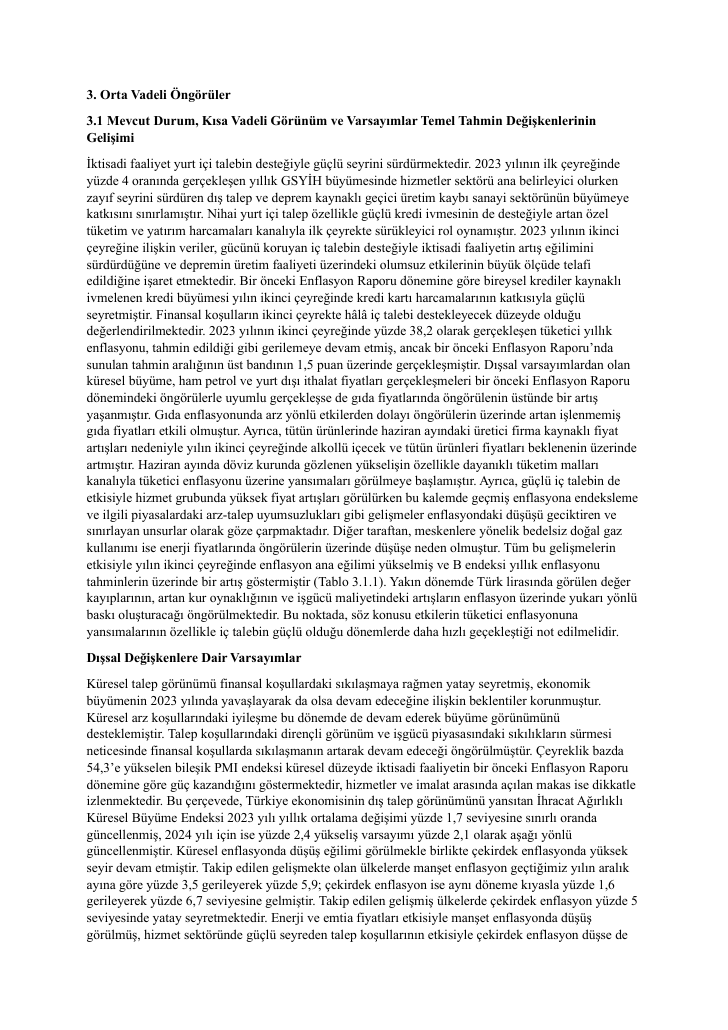

In [3]:
enflasyon = convert_from_path("pdfs/enflasyon.pdf", dpi=88)
enflasyon[0]

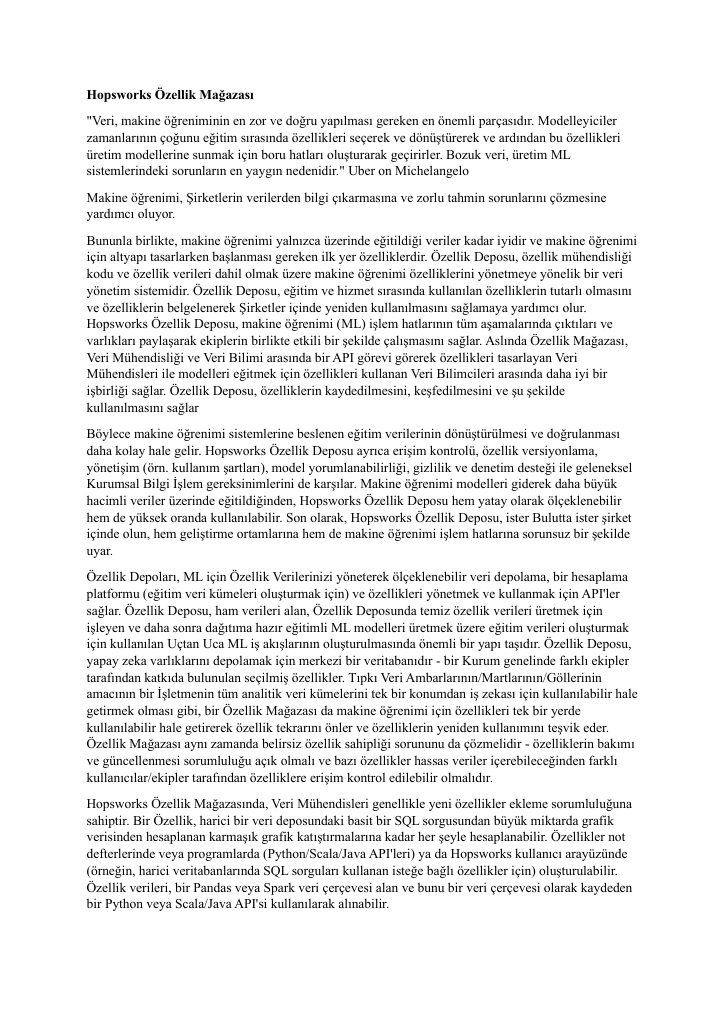

In [4]:
hopsworks = convert_from_path("pdfs/hopsworks.pdf", dpi=88)
hopsworks[0]

## Belirtilen dizindeki PDF dosyalarını yüklemek için PyPDFDirectoryLoader nesnesini oluşturur.

In [5]:
loader = PyPDFDirectoryLoader("pdfs")
docs = loader.load()
len(docs)

11

## Embedding işlemi için tercih edilen model

In [6]:
from langchain.embeddings import HuggingFaceEmbeddings
from sentence_transformers import SentenceTransformer
encoder = "emrecan/bert-base-turkish-cased-mean-nli-stsb-tr"

In [7]:
embeddings = HuggingFaceEmbeddings(model_name = encoder, encode_kwargs = {'normalize_embeddings' : False})

## chunk_size: 
Bu parametre, belirli bir belgenin metnini kaç karakterlik parçalara böleceğinizi belirler. Örneğin, 512 değeri, belgeyi 512 karakterlik parçalara böler.r.

## chunk_overlap: 
Bu parametre, ardışık parçalar arasındaki karakter örtüşmesini belirtir. Örtüşme, bir parça ile bir sonraki parça arasındaki karakterlerin kaç karakterle paylaşılacağını belirler. Örneğin, 128 değeri, her parçanın bir öncekine göre 128 karakteri paylaşmasını sağlar. Bağlamın korunması açısından önemlidir.

In [8]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=128)
texts = text_splitter.split_documents(docs)
len(texts)

105

## FAISS ve Chroma DB 
Herhangi birini seçebilirsiniz.

In [10]:
%%time
# db = Chroma.from_documents(texts, embeddings, persist_directory="db")
db = FAISS.from_documents(texts, embeddings)

CPU times: total: 14.1 s
Wall time: 7.6 s


## Türkçe desteği olması sebebi ile google/mT5 modelini tercih edilmiştir. Kullanılan model fine-tune edilmiş bir başka versiyonudur.

In [11]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Narrativa/mT5-base-finetuned-tydiQA-xqa")
model = AutoModelForSeq2SeqLM.from_pretrained("Narrativa/mT5-base-finetuned-tydiQA-xqa")

In [12]:
DEFAULT_SYSTEM_PROMPT = """
Siz yardımsever, saygılı ve dürüst bir asistansınız. Her zaman mümkün olduğunca yardımsever ve güvenli bir şekilde cevap verin. Yanıtlarınız zararlı, etik dışı, ırkçı, cinsiyetçi, zehirli, tehlikeli veya yasadışı içerik içermemelidir. Lütfen yanıtlarınızın sosyal açıdan tarafsız ve olumlu nitelikte olduğundan emin olun.

Bir soru mantıklı değilse veya gerçeklere dayanmıyorsa, doğru olmayan bir cevap vermek yerine nedenini açıklayın. Bir sorunun cevabını bilmiyorsanız, lütfen yanlış bilgi paylaşmayın.
""".strip()


def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
[INST] <>
{system_prompt}
<>

{prompt} [/INST]
""".strip()

In [13]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

## Pipeline -> Modelin temperature, top_p gibi parametrelerini değiştirerek test edebilirsiniz.

In [26]:
text_pipeline = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    temperature=0,
    top_p=0.95,
    streamer=streamer,
)

In [27]:
llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0})

## Modelin alakasız sorulara bilmiyorum demesini sağlamaya çalışıyoruz.

In [28]:
SYSTEM_PROMPT = "Sondaki soruyu cevaplamak için aşağıdaki bağlam parçalarını kullanın. Cevabı bilmiyorsanız, bilmediğinizi söyleyin, bir cevap uydurmaya çalışmayın."

template = generate_prompt(
    """
{context}

Question: {question}
""",
    system_prompt=SYSTEM_PROMPT,
)
     

In [29]:
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

## Bu kod, bir soru-cevap zincirini oluşturan bir nesne (qa_chain) yaratmak için kullanılıyor. Bu zincir, "RetrievalQA" sınıfından türetiliyor.

RetrievalQA.from_chain_type metodu, çeşitli parametrelerle çağrılarak özel bir soru-cevap zinciri oluşturuyor
. İşte temel parametreler

* llm: Language Model (Dil Modeli) olarak kullanılacak büyük dil modelini temsil eder.
* chain_type: Soru-cevap zincirinin tipini belirten bir parametredir. Burada "stuff" olarak belirtilmiştir.
* retriever: Bilgi çekme işlemlerini gerçekleştiren bir geri çekiciyi temsil eder. "db.as_retriever(search_kwargs={"k": 2})" ifadesi, db adlı bir veritabanını geri çekiciye dönüştürür ve bu geri çekicinin her sorgu için en iyi 2 belgeyi getirmesini sağlar.
* return_source_documents: Bu parametre, işlem sonucunda orijinal belgelerin döndürülüp döndürülmeyeceğini kontrol eder. True olarak belirtilmiş, yani orijinal belgelerin döndürülmesini sağlar.
* chain_type_kwargs: Zincirin tipine özgü parametreleri içerir. Bu örnekte "prompt" adlı bir parametre, kullanıcıdan alınan soruyu temsil eder.
Sonuç olarak, oluşturulan qa_chain nesnesi, belirli bir dil modelini, bilgi çekme işlemlerini ve zincir tipine özgü parametreleri birleştirerek soru-cevap zincirini tanımlar.tanımlar.

In [30]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

In [31]:
result = qa_chain("2023 yılı sonunda enflasyon yüzde kaçtır?")

58


In [42]:
result = qa_chain("Enflasyondaki düşüş eğilimi?")

devam etmektedir


In [41]:
result = qa_chain("Petrol fiyatları?")

78,1 dolar sev iyesinden 79,4 dolar seviyesine gözlenmektedir


In [44]:
result = qa_chain("Futbol nedir?")

Topu, kafa veya ayak vuruşları ile karşı kaleye sokma kuralına da


In [39]:
result = qa_chain("Futbolun oynandığı ilk 3 şehir?")

Istanbul, İzmi r, Selanik


In [40]:
result = qa_chain("İlk futbol kulübünün adı?")

Football Club Smyrna


In [48]:
result = qa_chain("İstanbul'da futbol ilk nerede oynanmıştır?")

Kadıköy ve Moda


In [34]:
result = qa_chain("Futbol maçı kaç dakikadır?")

45’şer


In [23]:
result = qa_chain("Makine öğrenimi neye yardımcı olmaktadır?")

Şirketlerin verilerden bilgi çıkarmasına ve zorlu tahmin sorunlarını çözmesine


## Gözlemler

* Promptlar oldukça önemlidir.
* Embedding modeli sonuçları etkilemektedir. Türkçe desteği daha kapsamlı olan embedding bir model ve LLM çalışmanın başarımını doğrudan etkileyecektir.
* Kullanılan dil modeli bağlamı yakalamada yetersizdir.
* Dil modeli tablo içindeki bilgileri almada yetersizdir.
* Veri gizliliğinin sorun olmadığı bir senaryoda OPEN API KEY ile GPT-3.5 kullanarak bu sistemi tasarlamak çok daha iyi sonuçlar verecektir.